In [14]:
from cifar10 import *
import matplotlib.pyplot as plt
import numpy as np
import timeit
import datetime
import sys

#!pip install scikit-image
from skimage import transform
import skimage

import tensorflow as tf

In [2]:
maybe_download_and_extract()
class_names = load_class_names()

train_data = load_training_data()
train_images_original = train_data[0]
train_labels_original = train_data[1]

Data has apparently already been downloaded and unpacked.
Loading data: data/cifar-10-batches-py/batches.meta
Loading data: data/cifar-10-batches-py/data_batch_1
Loading data: data/cifar-10-batches-py/data_batch_2
Loading data: data/cifar-10-batches-py/data_batch_3
Loading data: data/cifar-10-batches-py/data_batch_4
Loading data: data/cifar-10-batches-py/data_batch_5


In [3]:
test_data = load_test_data()
test_images = test_data[0]
test_labels = test_data[1]

Loading data: data/cifar-10-batches-py/test_batch


In [4]:
# Data centering and data normalization.
train_images_original = train_images_original.astype('float32')
mean = np.mean(train_images_original)  # mean for data centering
std = np.std(train_images_original)  # std for data normalization

train_images_original -= mean
train_images_original /= std

# Transform to range 0, 1
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

train_images_original = scale_range(train_images_original, 0, 1)

In [5]:
# Split to train and validation data
split = 0.9
split_loc = int(split * len(train_images_original))
              
validation_images = train_images_original[split_loc:]
validation_labels = train_labels_original[split_loc:]

train_images_split = train_images_original[:split_loc]
train_labels_split = train_labels_original[:split_loc]

In [9]:
# Horizontal flip to all training data
train_images_flip = np.flip(train_images_split, axis=2)
train_images_concat = np.concatenate((train_images_split, train_images_flip), axis=0)
train_labels_concat = np.concatenate((train_labels_split, train_labels_split), axis=0)


In [10]:
# Augment training data
def augment(image):
    size_x = image.shape[0]
    size_y = image.shape[1]
    # Rotation angle between -pi / 2, pi / 2 radians
    angle = np.random.random_sample() * 0.5*np.pi - 0.25*np.pi
    
    # Shear angle -0.25, 0.25 radians
    shear = np.random.random_sample() / 4 - 0.125
    
    # Translation -5 to 5 pixels in both directions
    translation_x = np.random.random_sample() * 10 - 5
    translation_y = np.random.random_sample() * 10 - 5
    translation = (0, 0)
    
    # Scale 1.0-1.5
    scale_x = np.random.random_sample() * 0.5 + 1
    scale_y = np.random.random_sample() * 0.5 + 1
    scale = (scale_x, scale_y)

    
    transform = skimage.transform.AffineTransform(rotation=angle,
                                                  shear=shear,
                                                  translation=translation, 
                                                  scale=scale)
    transformed_image = skimage.transform.warp(image, inverse_map=transform, mode='edge')
    
    # Randomly crop the image
    #rsize_x = np.random.randint(np.floor(0.9*size_x),size_x)
    #rsize_y = np.random.randint(np.floor(0.9*size_y),size_y)
    
    #w_s = np.random.randint(0,size_x - rsize_x)
    #h_s = np.random.randint(0,size_y - rsize_x)
    
    #cropped_image = transformed_image[w_s:w_s+size_x, h_s:h_s+size_y]
    
    resized_image = skimage.transform.resize(transformed_image, [32,32,3])
    
    return resized_image

In [12]:
amount_augmentations = 3
train_shape = np.shape(train_images_concat)
augment_shape = (train_shape[0]*3, train_shape[1], train_shape[2], train_shape[3])
augmented_images = np.zeros(augment_shape, dtype=np.float32)
augmented_labels = np.zeros((augment_shape[0]))


In [15]:
for i in range(train_shape[0]):
    for j in range(amount_augmentations):
        augmented = augment(train_images_concat[i])
        idx = i * amount_augmentations + j
        augmented_images[idx,:,:,:] = augmented
        augmented_labels[idx] = train_labels_concat[i]

train_images = augmented_images
train_labels = augmented_labels

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


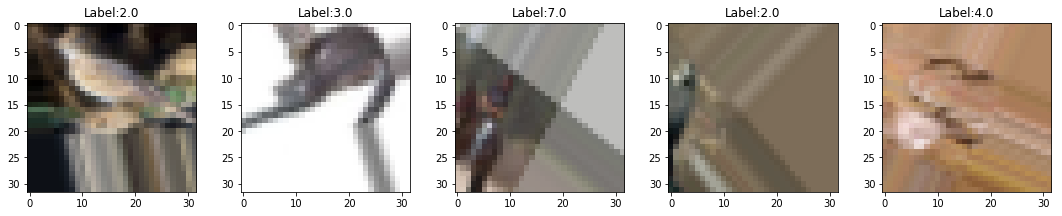

In [16]:
# Visualize a few images
amount = 5
idxs = np.random.randint(0, len(train_images), amount)

fig, axes = plt.subplots(1, amount, figsize=(15,15))
fig.tight_layout()
for i in range(0, amount):
    axes[i].imshow(train_images[idxs[i]])
    axes[i].set_title("Label:" + str(train_labels[idxs[i]]))


## Tensorflow implementation

In [17]:
X = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32, name='X')

In [18]:
# 32 maps of 6x6 capsules, outputs 8D activation vector
caps1_maps_amount = 32
caps1_caps_amount = caps1_maps_amount * 8 * 8
caps1_dims = 8

# First apply two regular convolutional layers
C1 = tf.layers.conv2d(X, 
                      filters=256, 
                      kernel_size = 9, 
                      strides=1, 
                      padding='valid', 
                      activation=tf.nn.relu, 
                      name='C1')

C2 = tf.layers.conv2d(C1, 
                      filters=(caps1_maps_amount*caps1_dims), 
                      kernel_size = 9, 
                      strides=2, 
                      padding='valid', 
                      activation=tf.nn.relu, 
                      name='C2')


In [19]:
np.shape(C2)

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(256)])

In [20]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [21]:
# Reshape to capsule
caps1_input = tf.reshape(C2, [-1, caps1_caps_amount, caps1_dims],
                       name="caps1_input")

# Calculate capsule output
caps1_output = squash(caps1_input, name='caps1_output')

In [22]:
# Image capsule layer
caps2_caps_amount = 10
caps2_dims = 16

init_sigma = 0.01

W_init = tf.random_normal(
    shape=(1, caps1_caps_amount, caps2_caps_amount, caps2_dims, caps1_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [23]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_caps_amount, 1, 1],
                             name="caps1_output_tiled")

In [24]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

In [25]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 2048, 10, 16, 1) dtype=float32>

## Routing by agreement

### Dynamic loop for routing

In [26]:
# Initialize routing weights to zero
raw_weights = tf.zeros([batch_size, caps1_caps_amount, caps2_caps_amount, 1, 1],
                       dtype=np.float32, name="raw_weights")

In [27]:
def routingNode(capsule_output, W, caps_prediction, raw_weights_initial=None):
    # X: Tiled output of a capsule layer
    # W: Current routing weights
    # caps_prediction: current prediction for the capsule layer outputs
    # raw_weights_initial: If the raw weights are already calculated, use them (First iteration)
    
    if raw_weights_initial is not None:
        raw_weights = raw_weights_initial
    
    else:
        agreement = tf.matmul(caps_prediction, capsule_output,
                          transpose_a=True, name="agreement")


        raw_weights = tf.add(W, agreement)

    routing_weights = tf.nn.softmax(raw_weights, dim=2)

    weighted_predictions = tf.multiply(routing_weights, caps_prediction)

    weighted_sum = tf.reduce_sum(weighted_predictions,
                                         axis=1, keep_dims=True)

    caps_output = squash(weighted_sum, axis=-2)
    
    return caps_output, raw_weights


In [28]:
# First routing node
caps2_output, raw_weights = routingNode(None, None, caps2_predicted, raw_weights)

# Loop for consequent routing nodes
total_routes = 4
for i in range(1,total_routes):
    caps2_output_tiled = tf.tile(caps2_output, [1, caps1_caps_amount, 1, 1, 1])

    caps2_output, raw_weights = routingNode(caps2_output_tiled, raw_weights, caps2_predicted)

## Estimating class probs

In [29]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [30]:
y_prob = safe_norm(caps2_output, axis=-2, name="y_prob")
y_prob_argmax = tf.argmax(y_prob, axis=2, name="y_prob")
y_pred = tf.squeeze(y_prob_argmax, axis=[1,2], name="y_pred")

## Labels

In [31]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [32]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [33]:
T = tf.one_hot(y, depth=caps2_caps_amount, name="T") # One hot encode labels

## Reconstruction as regularization

In [34]:
# Compute output vector for each output capsule and instance
print(caps2_output)

caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

Tensor("squash_3/mul:0", shape=(?, 1, 10, 16, 1), dtype=float32)


In [35]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

In [36]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

In [37]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [38]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

## Mask
Only send outputs to the reconstruction network from the capsule to which the image belongs

In [39]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [40]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [41]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_caps_amount,
                                 name="reconstruction_mask")

reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_caps_amount, 1, 1],
    name="reconstruction_mask_reshaped")

In [42]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

In [43]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [44]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_caps_amount * caps2_dims],
                           name="decoder_input")

In [45]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

## Decoder
Two fully connected ReLU followed with dense output sigmoid layer

In [46]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 32 * 32 * 3

In [47]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

## Reconstruction loss

In [48]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

## Final loss

In [49]:
alpha = 0.0001

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

## Calculate accuracy

In [50]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

## Training ops

In [51]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

In [52]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Training

In [53]:
def reset_batch(images, labels):
    # Shuffles the data
    p = np.random.permutation(len(images))
    shuffled_images = images[p]
    shuffled_labels = labels[p]
    return shuffled_images, shuffled_labels

def get_next_batch(batch_size, iteration, epoch_images, epoch_labels):
    batch_location = (iteration - 1)*batch_size
    batch_images = epoch_images[batch_location:batch_location+batch_size]
    batch_labels = epoch_labels[batch_location:batch_location+batch_size]
    
    return batch_images, batch_labels

In [ ]:
n_epochs = 10
batch_size = 100
restore_checkpoint = True

n_iterations_per_epoch = len(train_images) // batch_size
n_iterations_validation = len(validation_images) // batch_size
best_loss_val = np.infty
checkpoint_path = "./capsnet_"+str(datetime.datetime.now().time()).split('.')[0]
#checkpoint_path = "./capsnet_01:12:01"

training_loss_values = []


with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    
    for epoch in range(n_epochs):
        epoch_start_time = timeit.default_timer()
        epoch_images_train, epoch_labels_train = reset_batch(train_images, train_labels)
        epoch_images_validation, epoch_labels_validation = reset_batch(validation_images, validation_labels)

        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = get_next_batch(batch_size, iteration, 
                                              epoch_images_train, epoch_labels_train)
            
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 32, 32, 3]),
                           y: y_batch,
                           mask_with_labels: True})
            training_loss_values.append(loss_train)
            
            iteration_time = timeit.default_timer() - epoch_start_time
            print_line = "\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f} Seconds: {:.1f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train,
                      iteration_time)
            print(print_line, end="")
            sys.__stdout__.write(print_line)

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = get_next_batch(batch_size, iteration, 
                                              epoch_images_validation, epoch_labels_validation)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 32, 32, 3]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print_line = "\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation)
            print(print_line, end=" " * 10)
            sys.__stdout__.write(print_line)
            
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        epoch_time = (timeit.default_timer() - epoch_start_time)/60.0
        print_line = "\rEpoch: {} Train loss: {:.6f} Val accuracy: {:.4f}%  Loss: {:.6f} Minutes: {:.2f}{}".format(
            epoch + 1, loss_train, acc_val * 100, loss_val, epoch_time,
            " (improved)" if loss_val < best_loss_val else "")
        print(print_line)
        sys.__stdout__.write(print_line)
        
        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Iteration: 300/2700 (11.1%)  Loss: 0.46824 Seconds: 502.7

In [ ]:
# Plot training loss
plt.plot(training_loss_values)

## Run network with test data

In [ ]:
n_iterations_test = len(test_images) // batch_size
checkpoint_path = "./capsnet_01:12:01"
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = get_next_batch(batch_size, iteration, 
                                              test_images, test_labels)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 32, 32, 3]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))


## Make predictions

In [ ]:
n_samples = 5

idxs = np.random.randint(0,len(test_images), n_samples)
sample_images = test_images[idxs].reshape([-1, 32, 32, 3])
sample_labels = test_labels[idxs]

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})


In [ ]:
plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(test_labels[index]))
    plt.axis("off")

plt.show()

reconstructions = decoder_output_value.reshape([-1, 32, 32, 3])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()
